# 基于multi-query的查询转换

查询转换是一组专注于重写或修改问题以进行检索的方法。

![overview](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/query-overview.png?raw=1)

## 依赖

In [2]:
! pip3 install --quiet python-dotenv langchain langchain-community langchain-core langchain-openai beautifulsoup4 tiktoken pypdf langgraph langchain-pinecone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/

In [3]:
! pip install --upgrade --quiet  dashscope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00


## Environment

`(1) Packages`

In [ ]:
# 非colab环境
import os
from dotenv import load_dotenv

# 从 .env 文件加载所有环境变量
load_dotenv()

# LangSmith
langsmith_tracing = os.getenv('LANGSMITH_TRACING')
langsmith_endpoint = os.getenv('LANGSMITH_ENDPOINT')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

## LLM
dashscope_api_key = os.getenv('DASHSCOPE_API_KEY')

## Pinecone 向量数据库
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pinecone_api_host = os.getenv('PINECONE_API_HOST')
index_name = os.getenv('PINECONE_INDEX_NAME')

In [4]:
# Colab环境
import os
from google.colab import userdata

langsmith_tracing = userdata.get('LANGSMITH_TRACING')
langsmith_endpoint = userdata.get('LANGSMITH_ENDPOINT')
langsmith_api_key = userdata.get('LANGSMITH_API_KEY')

dashscope_api_key = userdata.get("DASHSCOPE_API_KEY")

pinecone_api_key = userdata.get('PINECONE_API_KEY')
pinecone_api_host = userdata.get('PINECONE_API_HOST')
index_name = userdata.get('PINECONE_INDEX_NAME')

`(2) LangSmith`

https://docs.smith.langchain.com/

In [5]:
os.environ['LANGSMITH_TRACING'] = langsmith_tracing
os.environ['LANGSMITH_ENDPOINT'] = langsmith_endpoint
os.environ['LANGSMITH_API_KEY'] = langsmith_api_key

`(3) API Keys`

In [6]:
# 使用阿里云百炼平台
os.environ['DASHSCOPE_API_KEY'] = dashscope_api_key
dashscope_model = "qwen-plus-latest"

#Pinecone keys
os.environ['PINECONE_API_KEY'] = pinecone_api_key
os.environ['PINECONE_API_HOST'] = pinecone_api_host
os.environ['PINECONE_INDEX_NAME'] = index_name

In [7]:
# langchain的webbaseloader需要
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"

## Multi Query RAG 架构

Flow:

![multi-query](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/multi-query.png?raw=1)

文档:

* https://python.langchain.com/docs/how_to/MultiQueryRetriever/

基于距离的[向量数据库](https://python.langchain.ac.cn/docs/concepts/vectorstores/)检索 [嵌入](https://python.langchain.ac.cn/docs/concepts/embedding_models/)（表示）多维空间中的查询，并基于距离度量找到相似的嵌入文档。但是，如果查询措辞略有变化，或者嵌入未能很好地捕捉数据语义，检索可能会产生不同的结果。有时会进行提示工程/调整来手动解决这些问题，但这可能很繁琐。

Multi Query RAG 架构通过使用 LLM 从不同角度为给定的用户输入查询生成多个查询，从而自动执行提示调整过程。对于每个查询，它检索一组相关文档，并取所有查询的唯一并集，以获得更大的潜在相关文档集。通过对同一问题生成多个角度，这种方法可以减轻基于距离的检索的一些限制，并获得更丰富的结果。


### 1. 构建索引

In [16]:
# Load blog
import bs4
from langchain_community.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import DashScopeEmbeddings
from langchain_pinecone import PineconeVectorStore
from pprint import pprint

#### 索引 ####

# Load Document (Uploading one file at a time)
pdf_file_path = "../langchain_turing.pdf" # or ../test/langchain_turing.pdf
loader = PyPDFLoader(pdf_file_path)

docs = loader.load()

# 上传来自一个文件的多个pdf文档
# pdf_file_paths = <enter your path here>
# loader = PyPDFDirectoryLoader(pdf_file_paths)

# docs_dir = loader.load()

# Splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000,
    chunk_overlap=500)

# split
splits = text_splitter.split_documents(docs)

# 嵌入、索引
def batch_read(lst, batch_size=10):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]

# 向量数据库用来存储嵌入向量和执行相似度搜索
embeddings=DashScopeEmbeddings(model="text-embedding-v4")
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)

for batch in batch_read(splits):
  vectorstore.add_documents(batch)

retriever = vectorstore.as_retriever()

确保Pincone有上传的文件

 ![Pinecone](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/pinecone.png?raw=1)


### 2. 生成多个query

#### 2.1 MultiQueryRetriever
MultiQueryRetriever 通过使用 LLM 从不同角度为给定的用户输入查询生成多个查询，从而自动化提示调整过程。对于每个查询，它检索一组相关文档，并取所有查询的唯一并集，以获得更大的潜在相关文档集。通过对同一问题生成多个角度，MultiQueryRetriever 可以减轻基于距离的检索的一些限制，并获得更丰富的结果。

In [20]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_community.chat_models.tongyi import ChatTongyi

question = "What are the approaches to Task Decomposition?"
query_llm = ChatTongyi(model=dashscope_model, temperature=0.1)
retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=retriever, llm=query_llm
)

In [21]:
# 通过logging获取查询生成结果
import logging

logging.basicConfig()
# 在info级别
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [22]:
unique_docs = retriever_from_llm.invoke(question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['What methods or strategies are commonly used for breaking down complex tasks into smaller components?', 'How can a large task be systematically divided into manageable subtasks?', 'What are the different techniques for decomposing a task in project management or problem-solving processes?']


9

#### 2.2 手动构建
在底层，MultiQueryRetriever 使用特定的 [提示](https://python.langchain.ac.cn/api_reference/langchain/retrievers/langchain.retrievers.multi_query.MultiQueryRetriever.html)生成查询。要自定义此提示

1. 创建一个 [PromptTemplate](https://python.langchain.ac.cn/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html)，其中包含问题的输入变量；
2. 实现一个如下所示的[输出解析器](https://python.langchain.ac.cn/docs/concepts/output_parsers/)，将结果拆分为查询列表。

提示和输出解析器必须共同支持生成查询列表。

In [23]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import BaseOutputParser

# Multi Query prompt
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

# Output parser will split the LLM result into a list of queries
# 输出解析器会切分LLM的结果文本为查询列表
class LineListOutputParser(BaseOutputParser[list[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # 去除空行

output_parser = LineListOutputParser()

generate_queries = (
    prompt_perspectives
    | ChatTongyi(model=dashscope_model, temperature=0.1)
    | output_parser
)

In [24]:
question = "How does LangChain leverage modular components like LangGraph, LangSmith, and LangServe to address challenges in building scalable and secure LLM-powered applications?"
generate_queries.invoke({"question":question})

['What are the roles of LangGraph, LangSmith, and LangServe in enhancing scalability and security within LLM-powered applications using LangChain?  ',
 'How do modular components such as LangGraph, LangSmith, and LangServe integrate with LangChain to overcome challenges in developing secure and scalable LLM applications?  ',
 'In what ways does LangChain utilize tools like LangGraph, LangSmith, and LangServe to ensure robustness and scalability in LLM-based systems?  ',
 "How can LangChain's modular architecture, including LangGraph, LangSmith, and LangServe, help developers build more secure and scalable applications powered by large language models?  ",
 'What benefits do LangGraph, LangSmith, and LangServe bring to LangChain in terms of addressing scalability and security concerns in LLM application development?']

In [25]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    # 展开列表的列表，并将每个文档转换为字符串
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    # 获取唯一的文档
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# 检索
question = "How does LangChain leverage modular components like LangGraph, LangSmith, and LangServe to address challenges in building scalable and secure LLM-powered applications?"

# map 返回 一个新的 Runnable 对象，它会将输入列表映射到输出列表
# 对每个输入调用invoke
map_retriver = retriever.map()

retrieval_chain = generate_queries | map_retriver | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

5

### 3. 生成

In [27]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# 生成 prompt
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatTongyi(model=dashscope_model, temperature=0.1)

####3.1 MultiQueryRetriever

In [28]:
final_rag_chain = (
    {"context": retriever_from_llm,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

print(final_rag_chain.invoke({"question":question}))

INFO:langchain.retrievers.multi_query:Generated queries: ['How does LangChain utilize tools such as LangGraph, LangSmith, and LangServe to enhance scalability and security in LLM-based applications?  ', 'What role do modular components like LangGraph, LangSmith, and LangServe play in LangChain when it comes to developing robust and secure applications powered by large language models?  ', "In what ways do LangChain's modules—LangGraph, LangSmith, and LangServe—help overcome common challenges in deploying scalable and secure LLM-powered systems?"]


LangChain leverages modular components like **LangGraph**, **LangSmith**, and **LangServe** to address challenges in building scalable and secure large language model (LLM)-powered applications as follows:

1. **LangGraph for Stateful Process Modeling**:  
   - LangGraph enables developers to design complex, stateful workflows by representing processes as graphs, where nodes represent actions or decisions and edges define transitions.
   - This modular approach allows developers to build contextually aware and dynamic applications that can maintain and manage state across interactions.
   - It integrates seamlessly with the broader LangChain ecosystem, allowing for incorporation of external tools and APIs as graph nodes while supporting independent operation when needed.

2. **LangSmith for Monitoring and Evaluation**:  
   - LangSmith provides tracing capabilities to monitor application performance, capturing detailed logs of agent interactions and node execution within LangGraph.
   

#### 3.2 手动构建

In [29]:
final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

print(final_rag_chain.invoke({"question":question}))

LangChain leverages modular components like **LangGraph**, **LangSmith**, and **LangServe** to address challenges in building scalable and secure applications powered by large language models (LLMs) in the following ways:

1. **LangGraph for Stateful Process Modeling**:  
   - LangGraph allows developers to structure complex workflows using nodes and edges, enabling branching logic and multi-agent interactions.  
   - It integrates with LangChain and LangSmith to provide tracing capabilities through LangSmith, allowing detailed monitoring of each node’s performance and logging of agent interactions.  
   - This enhances scalability by supporting dynamic, stateful processes while improving transparency and debugging capabilities, which are essential for maintaining security and reliability.

2. **LangSmith for Monitoring and Evaluation**:  
   - LangSmith provides tools for real-time performance monitoring, error tracking, and version control, helping developers iteratively optimize the

### 4. LangGraph

In [31]:
from langgraph.graph import START, StateGraph
from typing import List, TypedDict, Annotated
from langchain_core.documents import Document

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=retriever, llm=ChatTongyi(model=dashscope_model, temperature=0.1)
  )

# 定义应用的状态
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 定义检索节点
def retrieve(state: State):
  retrieved_docs = retriever_from_llm.invoke(state["question"])
  return {"context": retrieved_docs}

# 定义应用的生成节点
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# 构建图
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


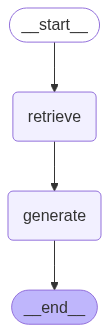

In [32]:
# 可视化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

INFO:langchain.retrievers.multi_query:Generated queries: ['What is the concept of Task Decomposition in project management?  ', 'How does Task Decomposition help in breaking down complex tasks?  ', 'What are the key principles and applications of Task Decomposition?']


Based on the provided context, **Task Decomposition** refers to the process of breaking down complex workflows or applications into smaller, manageable components or nodes that can be executed independently or in sequence. This concept is central to LangGraph’s functionality within the LangChain ecosystem.

In the context of **LangGraph**, Task Decomposition involves:

1. **Defining Nodes and State**: Developers initialize individual functions (nodes) such as calling an LLM, invoking a tool, or accessing external data. They also define the state schema to manage the application's context.

2. **Setting Entry Points and Edges**: Nodes are connected by edges that determine the flow of execution based on input conditions and application state. These transitions can be conditional or sequential.

3. **Compiling and Executing the Graph**: Once nodes and edges are defined, the graph is compiled into a runnable format. Functions like `invoke()` and `stream()` allow for execution and real-time

## Part 6: RAG-Fusion

RAG Fusion是一种先进的检索增强生成方法，它结合了多个检索源，每个检索源都专用于一个独特的上下文，以生成更准确、上下文丰富的响应。与独立执行和聚合结果而不混合的常规的multi-query不同，RAG Fusion动态选择和整合来自不同来源的信息，创建一个统一、连贯的答案，以适应复杂的查询。这种上下文相关信息的融合增强了响应的鲁棒性和相关性，使RAG fusion在处理多方面信息检索任务方面特别有效。

Flow:

![rag-fusion](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/rag-fusion.png?raw=1)

Docs:

* https://github.com/langchain-ai/langchain/blob/master/cookbook/rag_fusion.ipynb?ref=blog.langchain.dev

Blog / repo:

* https://medium.com/towards-data-science/forget-rag-the-future-is-rag-fusion-1147298d8ad1

RAG-Fusion：

Query Duplication with a Twist: 用 LLM 根据用户的 Query 生成几个相关的但不同的 Queries
Vector Search Unleashed：对原 Query 和生成的 Queries 都进行向量（或者其他方式的）搜索
Intelligent Reranking：使用 Reciprocal Rank Fusion 对搜索结果进行重新排序，挑选前 N 个。
Eloquent Finale: 把挑选的结果和问题一起，发给 LLM 让他生成最终的结果


### RAG Chain

In [34]:
# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [35]:
generate_queries = (
    prompt_rag_fusion
    | ChatTongyi(model=dashscope_model, temperature=0.1)
    | output_parser
)

In [38]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60, n=7):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula
        接受多个排名文档列表、RRF公式中使用的可选参数k、返回的文档数量
    """

    # 初始化字典以保存每个唯一文档的融合分数
    fused_scores = {}

    # 遍历每个排名文档列表
    for docs in results:
        # 遍历列表中的每个文档及其排名（列表中的位置）
        for rank, doc in enumerate(docs):
            # 将文档转换为字符串格式以用作key（假设文档可以序列化为JSON）
            doc_str = dumps(doc)
            # 如果文档尚未在fused_scores字典中，请将其初始分数添加为0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # 检索文档的当前分数（如果有的话）
            previous_score = fused_scores[doc_str]
            # 使用RRF公式更新文档的分数：1/（rank+k）
            fused_scores[doc_str] += 1 / (rank + k)

    # 根据fusion分数按降序对文档进行排序，以获得最终的重新排序结果
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # 将重新排序的结果作为元组列表返回，每个元组包含文档及其fusion分数
    return reranked_results[:n]

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

In [39]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

pprint(final_rag_chain.invoke({"question":question}))

('LangChain leverages modular components like **LangGraph**, **LangSmith**, '
 'and **LangServe** to address challenges in building scalable and secure '
 'large language model (LLM)-powered applications by providing specialized '
 'tools that streamline development, deployment, monitoring, and security. '
 "Here's how each component contributes:\n"
 '\n'
 '1. **LangGraph for Stateful Process Modeling:**\n'
 '   - LangGraph enables developers to build complex, stateful, and '
 'multi-agent workflows with fine-grained control over application logic.\n'
 '   - It supports cycles, branching, and persistence, which are essential for '
 'iterative or conditional processes in agentic architectures.\n'
 '   - Built-in **persistence** ensures continuity across sessions, crucial '
 'for applications like customer service agents or educational tools.\n'
 '   - Provides **human-in-the-loop** support, allowing manual intervention '
 'for oversight—particularly important in high-stakes domains such

## RAG Decomposition 架构

RAG分解（decomposition）架构是检索增强生成中的一个专门框架，旨在将复杂查询分解为更简单、可管理的子查询。每个子查询专注于大问题的一个特定部分，并发送到专门的检索器或数据库中以获取精确信息。这些子结果随后被整合和综合，形成对原始查询的连贯、全面的回答。这种架构提高了检索准确性，因为每个子查询针对特定上下文，减少了噪音，提高了最终响应的相关性。RAG分解特别适用于多部分问题、复杂主题或需要深入、细致回答的场景。

### Answer recursively  

![answer-recursively](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/answer-recursively.png?raw=1)

Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf

In [41]:
# Decomposition prompt
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [42]:
# Chain
generate_queries_decomposition = ( prompt_decomposition | query_llm | output_parser)

# Run
question = "What role does LangChain's Retrieval-Augmented Generation (RAG) pipeline play in improving the accuracy and relevance of LLM responses?"
questions = generate_queries_decomposition.invoke({"question":question})

In [43]:
questions

["1. How does LangChain's Retrieval-Augmented Generation (RAG) pipeline enhance the accuracy of responses from large language models?  ",
 '2. What is the role of external data retrieval in improving the relevance of LLM-generated answers within the RAG framework?  ',
 "3. How does the integration of retrieval and generation phases in LangChain's RAG pipeline impact overall model performance?"]

In [44]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [45]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

q_a_pairs = ""
for q in questions:

    # itemgetter获取对应字段的值
    rag_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")}
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [48]:
pprint(q_a_pairs)

('\n'
 '---\n'
 "Question: 1. How does LangChain's Retrieval-Augmented Generation (RAG) "
 'pipeline enhance the accuracy of responses from large language models?  \n'
 "Answer: LangChain's Retrieval-Augmented Generation (RAG) pipeline enhances "
 'the accuracy of responses from large language models (LLMs) by integrating '
 "external knowledge sources into the model's response generation process. "
 'Here’s how it works:\n'
 '\n'
 '1. **Access to External Knowledge**: The RAG pipeline allows LLMs to access '
 'up-to-date and domain-specific information beyond their training data. '
 'Documents in various formats (e.g., PDF, text, images) are preloaded, '
 'embedded, and stored in a vector store. This ensures that relevant '
 'contextual data can be retrieved and used during query processing.\n'
 '\n'
 '2. **Vector Embedding and Similarity Search**: Documents are transformed '
 'into numerical vector representations using embedding models. When a user '
 'submits a query, the system pe

In [46]:
pprint(answer)

("The integration of **retrieval and generation phases** in LangChain's "
 'Retrieval-Augmented Generation (RAG) pipeline has a significant positive '
 'impact on the **overall performance of large language models (LLMs)**. This '
 'integration enhances model behavior across several key dimensions, including '
 'accuracy, relevance, factual grounding, and contextual understanding.\n'
 '\n'
 '### Key Impacts on Model Performance:\n'
 '\n'
 '#### 1. **Improved Accuracy and Factual Consistency**\n'
 '- The retrieval phase fetches relevant, up-to-date, or domain-specific '
 'information from external knowledge sources (e.g., document databases, '
 'vector stores).\n'
 '- This retrieved context is then fed into the LLM during the generation '
 'phase, allowing it to ground its output in verified facts rather than '
 'relying solely on its pre-training data.\n'
 '- As a result, the model produces responses that are more factually accurate '
 'and consistent with current or specialized knowle

### Answer individually

或者，我们可以从每个单独的查询中获取答案，并将其直接传递给LLM，以根据之前的答案作为上下文生成最终答案。

![answer-individually](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/answer-individually.png?raw=1)

In [49]:
# Answer each sub-question individually
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt

template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Context: {context}
Question: {question}
Answer:
"""

prompt_rag = ChatPromptTemplate.from_template(template)
# prompt_rag = hub.pull("rlm/rag-prompt")
# template = " {question} "
# prompt_rag = ChatPromptTemplate.from_template(template)

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    retriever = vectorstore.as_retriever()

    # Use our decomposition /
    sub_questions = sub_question_generator_chain.invoke({"question":question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    for sub_question in sub_questions:

        print("sq :", sub_question)

        # Retrieve documents for each sub-question
        retrieved_docs = retriever.invoke(sub_question)
        print("rdocs: ", retrieved_docs)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, "question": sub_question})

        print("q: ", question)
        print("a: ", answer)

        rag_results.append(answer)

    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

sq : 1. How does LangChain's Retrieval-Augmented Generation (RAG) pipeline enhance the accuracy of responses from large language models?  
rdocs:  [Document(id='e58c9738-6d46-409e-8f9c-f29b625f6525', metadata={'author': '', 'creationdate': '2024-11-06T10:08:55+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2024-11-06T10:08:55+00:00', 'page': 2.0, 'page_label': '3', 'producer': 'pdfTeX-1.40.26', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) kpathsea version 6.4.0', 'source': '../langchain_turing.pdf', 'subject': '', 'title': '', 'total_pages': 14.0, 'trapped': '/False'}, page_content='LangChain 3\nneeds, providing a flexible foundation for building scalable, secure, and multi-\nfunctional applications. Figure 1 illustrates a fundamental LangChain pipeline.\nIn this architecture, diverse data sources—including documents, text, and im-\nages—are embedded and stored within a vector store. Upon receiving a user’s\nquery, the syste

In [50]:
print("qqq: ", questions, "\naaa: ", answers)

qqq:  ["1. How does LangChain's Retrieval-Augmented Generation (RAG) pipeline enhance the accuracy of responses from large language models?  ", '2. What is the role of external data retrieval in improving the relevance of LLM-generated answers within the RAG framework?  ', '3. How does the integration of retrieval and generation phases in LangChain’s RAG pipeline impact overall model performance?'] 
aaa:  ["LangChain's Retrieval-Augmented Generation (RAG) pipeline enhances the accuracy of responses by integrating external knowledge sources with large language models (LLMs). When a user submits a query, the system retrieves the most relevant information from a vector store and combines it with the query to provide contextual information to the LLM. This ensures that the generated response is factually grounded and enriched with up-to-date or domain-specific knowledge beyond the model’s training data.", "External data retrieval in the RAG framework enhances the relevance of LLM-generated

In [51]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""

    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)


print("Original Question:\n", question)
print("\nContext (including 3 question:answer pairs from modified query ):\n", context)

print("\nFinal Answer:\n", final_rag_chain.invoke({"context":context,"question":question}))

Original Question:
 What role does LangChain's Retrieval-Augmented Generation (RAG) pipeline play in improving the accuracy and relevance of LLM responses?

Context (including 3 question:answer pairs from modified query ):
 Question 1: 1. How does LangChain's Retrieval-Augmented Generation (RAG) pipeline enhance the accuracy of responses from large language models?  
Answer 1: LangChain's Retrieval-Augmented Generation (RAG) pipeline enhances the accuracy of responses by integrating external knowledge sources with large language models (LLMs). When a user submits a query, the system retrieves the most relevant information from a vector store and combines it with the query to provide contextual information to the LLM. This ensures that the generated response is factually grounded and enriched with up-to-date or domain-specific knowledge beyond the model’s training data.

Question 2: 2. What is the role of external data retrieval in improving the relevance of LLM-generated answers within

<!-- Trace:

https://smith.langchain.com/public/ed1cabf5-dea0-478b-8088-f7323d938a9b/r -->

## Part 8: Step Back

后退法是一种解决问题和信息检索的技术，它通过生成更抽象或更高层次的问题，而不是直接回答原问题。这种方法被称为“后退提示”，强调通过提出一般性问题来理解更广泛的背景和基本概念，从而提供更大的视角。该方法包括使用例子来引导抽象问题的形成，并允许独立检索与原问题和后退问题相关的信息。这种双重检索过程可以提升理解并生成更全面的回答，特别适用于技术文档和教科书等需要大量概念知识的领域，通过分别处理高层次概念及其详细实现来增强实用性。

![step-back](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/step-back.png?raw=1)

Paper:

* https://arxiv.org/pdf/2310.06117.pdf

In [52]:
# Few Shot 样本
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# 转换成相应的消息
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot 样本
        few_shot_prompt,
        # 新问题
        ("user", "{question}"),
    ]
)

In [53]:
generate_queries_step_back = prompt | llm | StrOutputParser()
question = "How does LangChain ensure security when integrating external services like vector databases and API providers in LLM applications?"
generate_queries_step_back.invoke({"question": question})

'What security measures does LangChain implement when connecting to external services in LLM applications?'

In [54]:
# Response prompt
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # 使用普通的问题检索上下文
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # 使用step-back问题检索上下文
        "step_back_context": generate_queries_step_back | retriever,
        # 传递question
        "question": lambda x: x["question"],
    } # 并行invoke
    | response_prompt
    | llm
    | StrOutputParser()
)

ans = chain.invoke({"question": question})

print(ans.strip())

LangChain ensures security when integrating external services like vector databases and API providers in LLM applications through a combination of best practices, internal controls, and advanced security features. These measures are designed to address the risks associated with data exposure and third-party dependencies, particularly for applications handling sensitive information.

### 1. **Granular Permissions**
LangChain enforces the principle of least privilege by allowing developers to define fine-grained permission settings. This minimizes the risk of unauthorized actions by restricting access to specific resources or operations based on user roles or application requirements. While current permissions are typically defined at deployment, future improvements could include dynamic adjustments based on real-time interactions or application states.

### 2. **Sandboxing and Defense-in-Depth**
To protect against potential vulnerabilities introduced by external integrations, LangChain 

## Part 9: HyDE

![hyde](https://github.com/tivon-x/bRAG-langchain/blob/main/notebooks/image/hyde.png?raw=1)

Docs:

* https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:

* https://arxiv.org/abs/2212.10496

In [55]:
from langchain.prompts import ChatPromptTemplate

# HyDE 文档生成
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | llm | StrOutputParser()
)

# Run
question = "How can LangChain's memory module be utilized to maintain context across multi-turn conversations in a chatbot application?"
generate_docs_for_retrieval.invoke({"question":question})

"LangChain's memory module plays a critical role in maintaining context across multi-turn conversations in chatbot applications by capturing, storing, and retrieving relevant interaction history. In conversational AI systems, where user inputs are often dependent on prior messages, preserving contextual information is essential for generating coherent and contextually accurate responses. LangChain addresses this need through its modular memory components, such as `ConversationBufferMemory`, `ConversationSummaryMemory`, and `CombinedMemory`, which enable the chatbot to retain varying levels of conversational history.\n\nThe `ConversationBufferMemory` stores the raw sequence of messages exchanged between the user and the chatbot, allowing the model to reference exact previous inputs and outputs. While effective for short-term context retention, this approach can become computationally expensive as the conversation lengthens. To mitigate this, `ConversationSummaryMemory` automatically gen

In [56]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(id='2220bd38-5524-4e38-9664-0097fd41be52', metadata={'author': '', 'creationdate': '2024-11-06T10:08:55+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2024-11-06T10:08:55+00:00', 'page': 3.0, 'page_label': '4', 'producer': 'pdfTeX-1.40.26', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) kpathsea version 6.4.0', 'source': '../langchain_turing.pdf', 'subject': '', 'title': '', 'total_pages': 14.0, 'trapped': '/False'}, page_content='4 Vasilios Mavroudis\nMemory: Enables applications to retain information from past interactions,\nsupporting both basic and advanced memory structures. This component is crit-\nical for maintaining context across sessions and delivering contextually aware\nresponses.\nIndexes: Serve as structured databases that organize and store information,\nallowing for efficient data retrieval when processing language queries.\nRetrievers: Designed to work alongside indexes, retrievers fetch relevant da

In [57]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'LangChain\'s **memory module** can be utilized to maintain context across multi-turn conversations in a chatbot application by storing and retrieving conversation history as needed. Specifically, the memory component enables the application to retain information from past interactions, which is critical for preserving context over time.\n\nFor a chatbot, this means:\n\n1. **Maintaining State**: The memory module keeps track of prior messages exchanged between the user and the chatbot. This allows the chatbot to reference previous interactions when generating responses, ensuring continuity during prolonged or complex conversations.\n\n2. **Contextual Awareness**: By leveraging stored conversation history, the chatbot can deliver responses that are contextually aware and relevant to the ongoing dialogue, rather than treating each query independently.\n\n3. **Structured Message Handling**: LangChain’s chat models use structured message sequences (e.g., roles like "user" and "assistant") 

## Conclusion

本笔记本全面介绍了检索增强生成（RAG）技术，特别强调了multi-query架构及其实际应用。

- 环境设置：提供了创建虚拟环境和安装必要软件包的详细说明。
- 数据加载和索引：讨论了使用Pinecone有效加载文档及其后续索引的方法。
- multi-query RAG：探索了生成用户查询多个视角的技术，以提高检索准确性。
- RAG融合和分解：提出了用于集成和分解查询的高级方法，以提高响应质量。
- 实际实现：包括使用LangChain和qwen模型实现这些技术的具体示例。

总之，本笔记本是跨各种应用程序实施RAG方法的宝贵资源，强调了上下文和查询多样性在信息检索任务领域的重要性。